### MACHINE LEARNING ALGORITHMS

In [1]:
import os
import numpy as np 
import pandas as pd 
from copy import deepcopy
import seaborn as sn
import itertools

import matplotlib.pyplot as plt
from matplotlib import style
from pandas import DataFrame,merge
style.use("ggplot")
%matplotlib inline

import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from xgboost import plot_importance
from matplotlib import pyplot
#from tpot import TPOTClassifier

### Read preprocessed data

In [2]:
dtrain = pd.read_csv('data/preprocessed_data.csv', header=0, sep=',', quotechar='"')

In [3]:
train = deepcopy(dtrain)

labels = train.loc[:,['OutcomeTypePrec']].values
del train['OutcomeTypePrec']
del train['AnimalID']

In [4]:
dtest = pd.read_csv('data/test_preprocessed_data.csv', header=0, sep=',', quotechar='"')

In [5]:
test = deepcopy(dtest)

animal_test_id = test.loc[:,['AnimalID']].values
del test['AnimalID']

In [6]:
full = train.append(test)

In [7]:
onehotdf = pd.get_dummies(full, prefix=['Hour', 'BreedPrec', 'ColorPrec'], 
                          columns=['Hour', 'BreedPrec', 'ColorPrec'])

onehotdf['AgeuponOutcomeProc'] = onehotdf["AgeuponOutcomeProc"] / onehotdf["AgeuponOutcomeProc"].max()
onehotdf['NameLen'] = onehotdf["NameLen"] / onehotdf["NameLen"].max()
onehotdf['NameFreq'] = onehotdf["NameFreq"] / onehotdf["NameFreq"].max()

In [8]:
len(onehotdf)

38185

In [9]:
onehotdf.head()

,NameBinary,NameLen,NameFreq,AnimalTypeBinary,AgeuponOutcomeProc,AgePrec,Month,Day,TimeOfDayPrec,YearPeriodPrec,...,ColorPrec_20,ColorPrec_21,ColorPrec_22,ColorPrec_23,ColorPrec_24,ColorPrec_25,ColorPrec_26,ColorPrec_27,ColorPrec_28,ColorPrec_29
0,1,0.583333,0.000550,1,0.045455,3,2,12,3,1,...,0,0,0,0,0,1,0,0,0,0
1,1,0.416667,0.002290,0,0.045455,2,10,13,2,2,...,0,1,0,0,0,0,0,0,0,0
2,1,0.500000,0.000183,1,0.090909,3,1,31,2,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0.250000,1.000000,0,0.002615,1,7,11,3,4,...,0,0,0,0,0,0,1,0,0,0
4,0,0.250000,1.000000,1,0.090909,3,11,15,2,2,...,0,0,0,0,0,0,0,0,0,0


In [10]:
f_train = onehotdf.head(26729)
f_test = onehotdf.tail(11456)

In [11]:
X = f_train.values # numpy array
# X = f_train # dataframe
y = labels.ravel()

In [12]:
print(X.shape)
print(y.shape)

(26729, 196)
(26729,)


In [14]:
# Split train and data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
print(X_train.shape)
print(y_train.shape)

(21383, 196)
(21383,)


### DecisionTreeClassifier()

In [16]:
decisionTree_model = tree.DecisionTreeClassifier()

decisionTree_model.fit(X_train, y_train)
df_predict = decisionTree_model.predict(X_test)
print("DecisionTreeClassifier Accuracy: {}%".format(accuracy_score(y_test, df_predict)*100))

DecisionTreeClassifier Accuracy: 60.88664421997755%


#### Confusion Matrix and Classification Report of DecisionTreeClassifier()

[[0.69152385 0.00277906 0.01482168 0.15562761 0.1352478 ]
 [0.06451613 0.09677419 0.16129032 0.12903226 0.5483871 ]
 [0.10248447 0.03726708 0.26708075 0.1863354  0.4068323 ]
 [0.31263158 0.00315789 0.06105263 0.40947368 0.21368421]
 [0.14808917 0.00849257 0.06050955 0.10138004 0.68152866]]


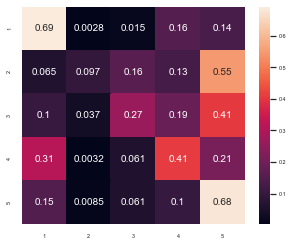

In [17]:
cm = confusion_matrix(y_test, df_predict) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(1, 6), range(1, 6))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [18]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, df_predict, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.71      0.69      0.70      2159
           Died       0.07      0.10      0.08        31
     Euthanasia       0.29      0.27      0.28       322
Return_to_owner       0.40      0.41      0.40       950
       Transfer       0.67      0.68      0.67      1884

       accuracy                           0.61      5346
      macro avg       0.43      0.43      0.43      5346
   weighted avg       0.61      0.61      0.61      5346



In [19]:
print(np.mean(cross_val_score(decisionTree_model, X_train, y_train, cv=5)))

0.5989803729697843


### SVM()

#### SVM Clf

In [20]:
svm_model = SVC(probability=True)

svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy: {}%".format(accuracy_score(y_test, svm_predictions)*100))

SVM Accuracy: 62.32697343808455%


[[0.82399259 0.         0.         0.07874016 0.09726725]
 [0.19354839 0.         0.         0.06451613 0.74193548]
 [0.19565217 0.         0.00310559 0.23602484 0.56521739]
 [0.51473684 0.         0.         0.39263158 0.09263158]
 [0.28450106 0.         0.         0.08970276 0.62579618]]


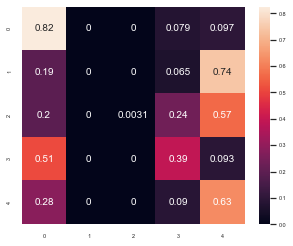

In [21]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [22]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, svm_predictions, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.62      0.82      0.71      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       1.00      0.00      0.01       322
Return_to_owner       0.47      0.39      0.43       950
       Transfer       0.70      0.63      0.66      1884

       accuracy                           0.62      5346
      macro avg       0.56      0.37      0.36      5346
   weighted avg       0.64      0.62      0.60      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(np.mean(cross_val_score(svm_model, X_train, y_train, cv=5)))

0.6191833185225301


#### SVM Linear Clf

In [24]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 

svm_linear_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
print("SVM Linear Accuracy: {}%".format(accuracy*100))

SVM Linear Accuracy: 63.13131313131313%


[[0.79851783 0.         0.00277906 0.07503474 0.12366836]
 [0.19354839 0.         0.         0.06451613 0.74193548]
 [0.1863354  0.         0.02795031 0.19875776 0.58695652]
 [0.46736842 0.         0.         0.41263158 0.12      ]
 [0.24787686 0.         0.00159236 0.08704883 0.66348195]]


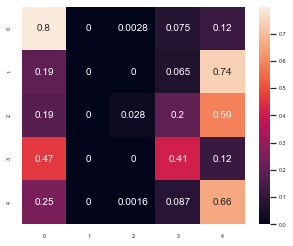

In [25]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_linear_predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [26]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, svm_linear_predictions, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.64      0.80      0.71      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.50      0.03      0.05       322
Return_to_owner       0.50      0.41      0.45       950
       Transfer       0.68      0.66      0.67      1884

       accuracy                           0.63      5346
      macro avg       0.46      0.38      0.38      5346
   weighted avg       0.62      0.63      0.61      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(np.mean(cross_val_score(svm_model_linear, X_train, y_train, cv=5)))

0.6282557539588369


#### SVM Poly Clf

In [28]:
svm_model_poly = SVC(gamma='auto',kernel='poly').fit(X_train, y_train) 

svm_poly_predictions = svm_model_poly.predict(X_test) 
  
accuracy = svm_model_poly.score(X_test, y_test) 
print("SVM Poly Accuracy: {}%".format(accuracy*100))

SVM Poly Accuracy: 64.12270856715301%


[[8.56415007e-01 0.00000000e+00 9.26354794e-04 6.43816582e-02
  7.82769801e-02]
 [1.93548387e-01 0.00000000e+00 0.00000000e+00 3.22580645e-02
  7.74193548e-01]
 [2.36024845e-01 0.00000000e+00 3.10559006e-03 1.64596273e-01
  5.96273292e-01]
 [5.62105263e-01 0.00000000e+00 0.00000000e+00 3.32631579e-01
  1.05263158e-01]
 [2.63800425e-01 0.00000000e+00 5.30785563e-04 6.58174098e-02
  6.69851380e-01]]


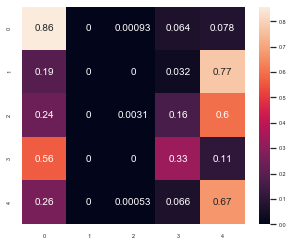

In [29]:
cm = confusion_matrix(y_test, svm_poly_predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [30]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, svm_poly_predictions, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.62      0.86      0.72      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.25      0.00      0.01       322
Return_to_owner       0.50      0.33      0.40       950
       Transfer       0.72      0.67      0.70      1884

       accuracy                           0.64      5346
      macro avg       0.42      0.37      0.36      5346
   weighted avg       0.61      0.64      0.61      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print(np.mean(cross_val_score(svm_model_poly, X_train, y_train, cv=5)))

0.6336809479555733


### KNeighborsClassifier()

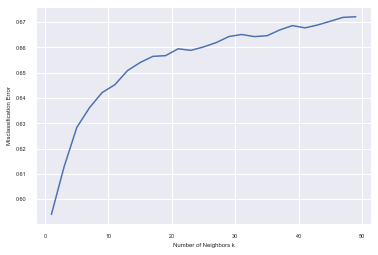

1
KNN Accuracy: 59.951365506921064%


In [32]:
# training a KNN classifier 
myList = list(range(1,50))
neighbors = list(filter(lambda x: x%2!=0, myList))
cv_scores = []
for k in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
mean_error = [1-x for x in cv_scores]

plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

optimal_k = neighbors[mean_error.index(min(mean_error))]
print(optimal_k)

knn_model = KNeighborsClassifier(n_neighbors = optimal_k, n_jobs=-1)
knn_model.fit(X_train, y_train)
pred_knn = knn_model.predict(X_test)
print("KNN Accuracy: {}%".format(accuracy_score(y_test, pred_knn)*100))

#### Confusion Matrix and Classification Report of KNeighborsClassifier()

[[0.65076424 0.00231589 0.02686429 0.16072256 0.15933302]
 [0.29032258 0.03225806 0.22580645 0.06451613 0.38709677]
 [0.22049689 0.01552795 0.19254658 0.20186335 0.36956522]
 [0.38210526 0.00210526 0.04210526 0.40947368 0.16421053]
 [0.1507431  0.00530786 0.0329087  0.0955414  0.71549894]]


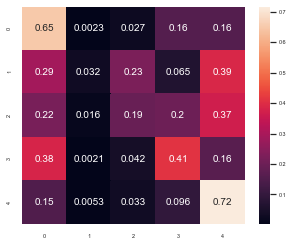

In [33]:
cm = confusion_matrix(y_test, pred_knn) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [34]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, pred_knn, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.66      0.65      0.65      2159
           Died       0.04      0.03      0.04        31
     Euthanasia       0.27      0.19      0.23       322
Return_to_owner       0.40      0.41      0.40       950
       Transfer       0.68      0.72      0.70      1884

       accuracy                           0.60      5346
      macro avg       0.41      0.40      0.40      5346
   weighted avg       0.59      0.60      0.60      5346



In [35]:
print(np.mean(cross_val_score(knn_model, X_train, y_train, cv=5)))

0.5854177269896873


### GaussianNB()

In [36]:
gnb = GaussianNB().fit(X_train, y_train) 

gnb_pred = gnb.predict(X_test) 
  
accuracy = gnb.score(X_test, y_test) 
print("GaussianNB Accuracy: {}% \n".format(accuracy*100))

cm = confusion_matrix(y_test, gnb_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, gnb_pred, target_names=target_names))

print(np.mean(cross_val_score(gnb, X_train, y_train, cv=5)))

GaussianNB Accuracy: 3.5166479610924055% 

[[0.01899027 0.77350625 0.12459472 0.07503474 0.00787402]
 [0.03225806 0.87096774 0.06451613 0.03225806 0.        ]
 [0.00310559 0.86956522 0.07453416 0.04658385 0.00621118]
 [0.01894737 0.72526316 0.17473684 0.07894737 0.00210526]
 [0.00636943 0.86942675 0.06900212 0.0440552  0.0111465 ]]
                 precision    recall  f1-score   support

       Adoption       0.56      0.02      0.04      2159
           Died       0.01      0.87      0.01        31
     Euthanasia       0.04      0.07      0.05       322
Return_to_owner       0.22      0.08      0.12       950
       Transfer       0.50      0.01      0.02      1884

       accuracy                           0.04      5346
      macro avg       0.27      0.21      0.05      5346
   weighted avg       0.45      0.04      0.05      5346

0.040873453915071654


### MLPClassifier()

In [37]:
MLP_model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(15, 10, 5), random_state=1)
MLP_model.fit(X_train, y_train)

MLP_pred = MLP_model.predict(X_test) 

accuracy = MLP_model.score(X_test, y_test) 
print("MLP Accuracy: {}%".format(accuracy*100))

MLP Accuracy: 66.8163112607557%


c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Confusion Matrix and Classification Report of MLPClassifier()

[[0.84437239 0.         0.00277906 0.08290875 0.06993979]
 [0.06451613 0.         0.12903226 0.09677419 0.70967742]
 [0.1552795  0.         0.20496894 0.20186335 0.4378882 ]
 [0.43894737 0.         0.00842105 0.40842105 0.14421053]
 [0.20912951 0.         0.01910828 0.0843949  0.6873673 ]]


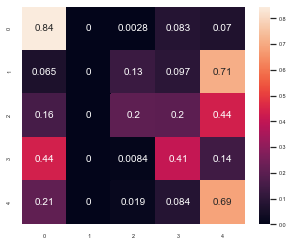

In [38]:
cm = confusion_matrix(y_test, MLP_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [39]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, MLP_pred, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.68      0.84      0.75      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.55      0.20      0.30       322
Return_to_owner       0.49      0.41      0.44       950
       Transfer       0.74      0.69      0.71      1884

       accuracy                           0.67      5346
      macro avg       0.49      0.43      0.44      5346
   weighted avg       0.66      0.67      0.65      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print(np.mean(cross_val_score(MLP_model, X_train, y_train, cv=5)))

c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6583261284224602


c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### RandomForestClassifier()

In [41]:
"""# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 550, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores AND .fit(x,y)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1).fit(onehotdf,y)"""

"# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 50, stop = 550, num = 100)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestCla

In [42]:
grid_search_random_forest = RandomForestClassifier(n_estimators=408, min_samples_split=10,
                                                   min_samples_leaf=2, max_features='sqrt', max_depth=None,
                                                   bootstrap=True)

In [43]:
grid_search_random_forest.fit(X_train, y_train)

rf_predictions = grid_search_random_forest.predict(X_test) 
accuracy = grid_search_random_forest.score(X_test, y_test) 
print("RandomForest Accuracy: {}%".format(accuracy*100))

RandomForest Accuracy: 68.5746352413019%


#### Confusion Matrix and Classification Report of RandomForestClassifier()

[[8.54562297e-01 0.00000000e+00 0.00000000e+00 9.07827698e-02
  5.46549328e-02]
 [3.22580645e-02 0.00000000e+00 0.00000000e+00 9.67741935e-02
  8.70967742e-01]
 [1.70807453e-01 0.00000000e+00 8.07453416e-02 2.11180124e-01
  5.37267081e-01]
 [4.27368421e-01 0.00000000e+00 0.00000000e+00 4.67368421e-01
  1.05263158e-01]
 [1.93736730e-01 0.00000000e+00 5.30785563e-04 8.86411890e-02
  7.17091295e-01]]


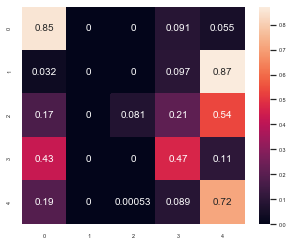

In [44]:
cm = confusion_matrix(y_test, rf_predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [45]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, rf_predictions, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.69      0.85      0.76      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.96      0.08      0.15       322
Return_to_owner       0.51      0.47      0.49       950
       Transfer       0.76      0.72      0.74      1884

       accuracy                           0.69      5346
      macro avg       0.58      0.42      0.43      5346
   weighted avg       0.70      0.69      0.66      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print(np.mean(cross_val_score(grid_search_random_forest, X_train, y_train, cv=5)))

0.6809615379147453


### LogisticRegression()

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
logreg_predictions = logreg.predict(X_test) 
accuracy = logreg.score(X_test, y_test) 
print("LogisticRegression Accuracy: {}%".format(accuracy*100))

LogisticRegression Accuracy: 63.20613542835765%


c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Confusion Matrix and Classification Report of LogisticRegression()

[[0.7786012  0.         0.00231589 0.08846688 0.13061603]
 [0.12903226 0.         0.06451613 0.09677419 0.70967742]
 [0.16459627 0.         0.10869565 0.21428571 0.51242236]
 [0.44       0.         0.00315789 0.42736842 0.12947368]
 [0.23248408 0.         0.007431   0.09288747 0.66719745]]


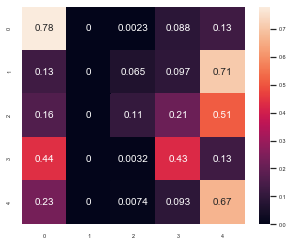

In [48]:
cm = confusion_matrix(y_test, logreg_predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [49]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, logreg_predictions, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.65      0.78      0.71      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.59      0.11      0.18       322
Return_to_owner       0.48      0.43      0.45       950
       Transfer       0.68      0.67      0.67      1884

       accuracy                           0.63      5346
      macro avg       0.48      0.40      0.40      5346
   weighted avg       0.62      0.63      0.61      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print(np.mean(cross_val_score(logreg, X_train, y_train, cv=5)))

c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

0.6248424087506148


c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### PCA - LDA

In [51]:
pca = PCA(n_components=10)
X = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_.cumsum())

[0.75754447 0.88217047 0.92470404 0.94664792 0.95886763 0.96457793
 0.96839173 0.97177388 0.97466304 0.97687876]


In [52]:
# X_pca = PCA(2).fit_transform(X_train)
# kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 5), edgecolor='none', alpha=0.6)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, **kwargs)

In [53]:
lda = LDA()
print(np.mean(cross_val_score(lda, X_train, y_train, cv=5))) 

0.6151614581704344


### XGBClassifier()

In [54]:
n_iter = 1000
k_fold = 5
 
cv = StratifiedKFold(n_splits=k_fold,shuffle=True)
 
# initialize the classifier
GB = xgb.XGBClassifier(n_estimators=115) #, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)
 
param_grid = {'max_depth': sp_randint(1, 90),
              'learning_rate': sp_uniform(loc=0e0,scale=1e0),
              'objective':['multi:softprob'],
              'nthread': [8],
              'missing': [np.nan],
              'reg_alpha': [0.01,0.017782794,0.031622777,0.056234133,\
                            0.1,0.17782794,0.31622777,0.56234133,1.,1.77827941,\
                            3.16227766,5.62341325,10.,\
                            17.7827941,31.6227766,56.2341325,100.],
              'colsample_bytree': sp_uniform(loc=0.2e0,scale=0.8e0),
              'subsample': sp_uniform(loc=0.2e0,scale=0.8e0),
              'n_estimators': sp_randint(50, 200)}

In [55]:
# search_GB = RandomizedSearchCV(GB, param_grid, scoring='neg_log_loss',\
#                n_iter=n_iter, cv=cv, verbose=True, n_jobs = 1).fit(X_train, y_train)
# print(search_GB.best_score_)
# print(search_GB.best_params_)

In [56]:
# save the results
# f_name = open('data\xgboost_RSCV.dat','w')
# pickle.dump([search_GB.grid_scores_],f_name)
# f_name.close()

# f_name = open('data\xgboost_params.dat','w')
# pickle.dump([search_GB.best_params_],f_name)
# f_name.close()

In [57]:
XGB_model = xgb.XGBClassifier(reg_alpha=1.77827941, n_jobs=-1, colsample_bytree=0.5722532094026564, 
                              objective='multi:softprob', n_estimators=115, max_depth=22, 
                              learning_rate=0.07578955028741008, subsample=0.848348985132586)

In [58]:
XGB_model.fit(X_train,y_train)

XGB_pred = XGB_model.predict(X_test)
print("XGB Accuracy:", XGB_model.score(X_test, y_test))

XGB Accuracy: 0.6971567527123083


#### Plotting Feature Importance

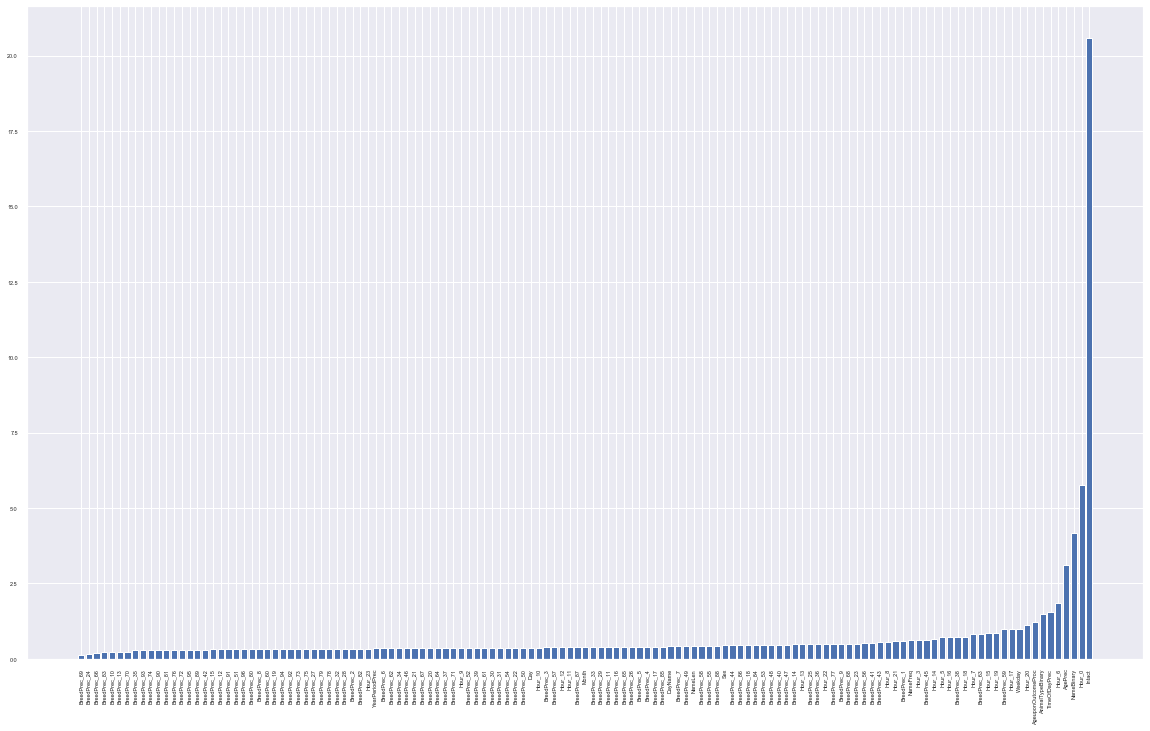

In [59]:
tmp = XGB_model.get_booster().get_score(importance_type="gain")
s_tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: int(item[0][1:]))}
# s_tmp = {k: v for k, v in tmp.items()}
tmp = dict((f_train.columns[i], value) for i, (key, value) in enumerate(s_tmp.items()))

sorted_tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
pyplot.figure(figsize=(20,12))
pyplot.bar(list(sorted_tmp.keys()), list(sorted_tmp.values()))
pyplot.xticks(rotation=90)

pyplot.show()

In [60]:
# printing sorted features by how important they are...
sorted_tmp

{'BreedPrec_69': 0.1347999575,
 'BreedPrec_24': 0.14435342943333332,
 'BreedPrec_66': 0.19263573736250003,
 'BreedPrec_83': 0.2334954735,
 'BreedPrec_10': 0.23464574671249996,
 'BreedPrec_13': 0.23922412600833332,
 'BreedPrec_70': 0.2410297395,
 'BreedPrec_35': 0.2753504345,
 'BreedPrec_93': 0.28986620890938364,
 'BreedPrec_74': 0.29033831753293776,
 'BreedPrec_90': 0.296063322203392,
 'BreedPrec_81': 0.2975276547416632,
 'BreedPrec_76': 0.2979716764339947,
 'BreedPrec_72': 0.30003563275542117,
 'BreedPrec_95': 0.30538974699958193,
 'BreedPrec_89': 0.3061557440276539,
 'BreedPrec_42': 0.3072857329,
 'BreedPrec_15': 0.3119078730415584,
 'BreedPrec_12': 0.3121140628379866,
 'BreedPrec_91': 0.31404440103009285,
 'BreedPrec_51': 0.3141713143721067,
 'BreedPrec_96': 0.31626356449166665,
 'BreedPrec_80': 0.3186976549643878,
 'BreedPrec_8': 0.3188767664507041,
 'BreedPrec_60': 0.31901128667234796,
 'BreedPrec_19': 0.31904021486666856,
 'BreedPrec_94': 0.3203078132039661,
 'BreedPrec_92': 0.32

#### Confusion Matrix and Classification Report of XGBoost

[[8.15655396e-01 0.00000000e+00 4.63177397e-04 1.10236220e-01
  7.36452061e-02]
 [3.22580645e-02 3.22580645e-02 9.67741935e-02 9.67741935e-02
  7.41935484e-01]
 [1.24223602e-01 0.00000000e+00 2.39130435e-01 2.04968944e-01
  4.31677019e-01]
 [3.65263158e-01 0.00000000e+00 4.21052632e-03 5.08421053e-01
  1.22105263e-01]
 [1.56050955e-01 5.30785563e-04 1.27388535e-02 8.49256900e-02
  7.45753715e-01]]


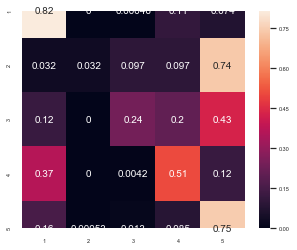

In [61]:
cm = confusion_matrix(y_test, XGB_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [62]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, XGB_pred, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      2159
           Died       0.50      0.03      0.06        31
     Euthanasia       0.71      0.24      0.36       322
Return_to_owner       0.51      0.51      0.51       950
       Transfer       0.76      0.75      0.75      1884

       accuracy                           0.70      5346
      macro avg       0.64      0.47      0.49      5346
   weighted avg       0.70      0.70      0.69      5346



### ADABoost and Random Forests

In [68]:
clf = RandomForestClassifier(n_estimators=115, min_samples_split=10,
                                                   min_samples_leaf=2, max_features='sqrt', max_depth=None,
                                                   bootstrap=True)
bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=clf.n_estimators)

bclf.fit(X_train,y_train)

bclf_pred = bclf.predict(X_test)
print("Adaboost Random Forest Accuracy: {}%".format(bclf.score(X_test, y_test)*100))

Adaboost Random Forest Accuracy: 68.14440703329592%


#### Confusion Matrix and Classification Report of ADABoost and Random Forests

[[0.81056044 0.         0.00138953 0.1065308  0.08151922]
 [0.06451613 0.03225806 0.09677419 0.09677419 0.70967742]
 [0.09627329 0.         0.22360248 0.22049689 0.45962733]
 [0.39894737 0.         0.00315789 0.46631579 0.13157895]
 [0.17038217 0.         0.01167728 0.08704883 0.73089172]]


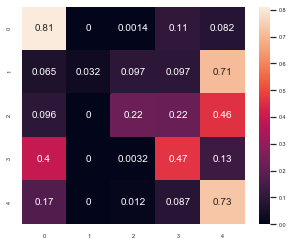

In [69]:
cm = confusion_matrix(y_test, bclf_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [70]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, bclf_pred, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.70      0.81      0.75      2159
           Died       1.00      0.03      0.06        31
     Euthanasia       0.70      0.22      0.34       322
Return_to_owner       0.49      0.47      0.48       950
       Transfer       0.75      0.73      0.74      1884

       accuracy                           0.68      5346
      macro avg       0.73      0.45      0.47      5346
   weighted avg       0.68      0.68      0.67      5346



In [71]:
print(np.mean(cross_val_score(bclf, X_train, y_train, cv=5)))

0.6779686766271962


### ADABoost and Decision Tree

In [76]:
bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=500)

bdt.fit(X_train, y_train)
y_pred_ada = bdt.predict(X_test)
accAda = accuracy_score(y_test, y_pred_ada)
print("Adaboost Decision Tree Accuracy: {}%".format(accAda*100))

Adaboost Decision Tree Accuracy: 68.2005237560793%


#### Confusion Matrix and Classification Report of ADABoost and Decision Tree

[[0.83974062 0.         0.00185271 0.09170912 0.06669755]
 [0.06451613 0.         0.06451613 0.09677419 0.77419355]
 [0.13975155 0.         0.16770186 0.18322981 0.50931677]
 [0.42947368 0.         0.00736842 0.43368421 0.12947368]
 [0.19267516 0.         0.00955414 0.07218684 0.72558386]]


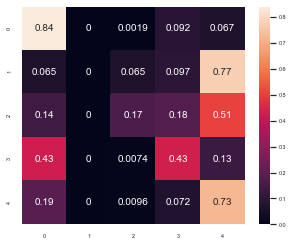

In [77]:
cm = confusion_matrix(y_test, y_pred_ada)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [78]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, y_pred_ada, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.64      0.17      0.27       322
Return_to_owner       0.51      0.43      0.47       950
       Transfer       0.75      0.73      0.74      1884

       accuracy                           0.68      5346
      macro avg       0.52      0.43      0.45      5346
   weighted avg       0.67      0.68      0.66      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
print(np.mean(cross_val_score(bdt, X_train, y_train, cv=5)))

0.659587120878246


### Gradient Boosting using sklearn

In [80]:
clf = GradientBoostingClassifier(n_estimators=115, subsample=0.848348985132586,min_samples_leaf=2, 
                                 learning_rate=0.07578955028741008,max_depth=22, 
                                 random_state=42).fit(X_train, y_train)
y_pred_gb = clf.predict(X_test)
print("Gradient Boosting Accuracy: {}%".format(clf.score(X_test, y_test)*100))

Gradient Boosting Accuracy: 68.23793490460157%


#### Confusion Matrix and Classification Report of Gradient Boosting

[[8.13339509e-01 4.63177397e-04 9.26354794e-04 1.13941640e-01
  7.13293191e-02]
 [6.45161290e-02 3.22580645e-02 1.61290323e-01 1.29032258e-01
  6.12903226e-01]
 [1.24223602e-01 9.31677019e-03 2.20496894e-01 2.08074534e-01
  4.37888199e-01]
 [3.77894737e-01 0.00000000e+00 1.05263158e-02 4.67368421e-01
  1.44210526e-01]
 [1.60828025e-01 2.65392781e-03 1.96390658e-02 8.65180467e-02
  7.30360934e-01]]


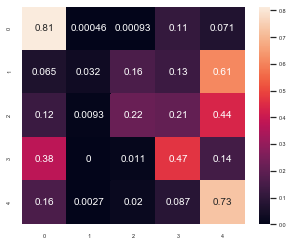

In [81]:
cm = confusion_matrix(y_test, y_pred_gb)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [82]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, y_pred_gb, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.76      2159
           Died       0.10      0.03      0.05        31
     Euthanasia       0.57      0.22      0.32       322
Return_to_owner       0.48      0.47      0.47       950
       Transfer       0.75      0.73      0.74      1884

       accuracy                           0.68      5346
      macro avg       0.52      0.45      0.47      5346
   weighted avg       0.67      0.68      0.67      5346



In [83]:
print(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

0.6833465839536337


### VotingClassifier()

#### estimators= ('rf', grid_search_random_forest), ('xgb', XGB_model), ('svm', svm_model), voting='soft'

In [84]:
eclf1 = VotingClassifier(estimators=[('rf', grid_search_random_forest), ('xgb', XGB_model), 
                                     ('svm', svm_model)], voting='soft')
eclf1.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
       

In [85]:
eclf1_pred = eclf1.predict(X_test)
print("Voting Accuracy: {}%".format(eclf1.score(X_test, y_test)*100))

Voting Accuracy: 68.66816311260756%


[[8.42982862e-01 0.00000000e+00 4.63177397e-04 9.03195924e-02
  6.62343678e-02]
 [6.45161290e-02 0.00000000e+00 3.22580645e-02 9.67741935e-02
  8.06451613e-01]
 [1.18012422e-01 0.00000000e+00 1.39751553e-01 2.39130435e-01
  5.03105590e-01]
 [4.35789474e-01 0.00000000e+00 2.10526316e-03 4.57894737e-01
  1.04210526e-01]
 [1.78874735e-01 0.00000000e+00 7.96178344e-03 8.54564756e-02
  7.27707006e-01]]


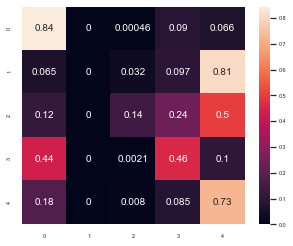

In [86]:
cm = confusion_matrix(y_test, eclf1_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [87]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, eclf1_pred, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.70      0.84      0.76      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.70      0.14      0.23       322
Return_to_owner       0.50      0.46      0.48       950
       Transfer       0.76      0.73      0.74      1884

       accuracy                           0.69      5346
      macro avg       0.53      0.43      0.44      5346
   weighted avg       0.68      0.69      0.67      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### estimators= ('rf', grid_search_random_forest), ('xgb', XGB_model), ('knn', knn_model), voting='soft'

In [88]:
eclf2 = VotingClassifier(estimators=[('rf', grid_search_random_forest), ('xgb', XGB_model), 
                                     ('knn', knn_model)], voting='soft')
eclf2.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
       

In [89]:
eclf2_pred = eclf1.predict(X_test)
print("Voting Accuracy: {}%".format(eclf2.score(X_test, y_test)*100))

Voting Accuracy: 64.88963711185933%


[[8.42982862e-01 0.00000000e+00 4.63177397e-04 9.03195924e-02
  6.62343678e-02]
 [6.45161290e-02 0.00000000e+00 3.22580645e-02 9.67741935e-02
  8.06451613e-01]
 [1.18012422e-01 0.00000000e+00 1.39751553e-01 2.39130435e-01
  5.03105590e-01]
 [4.35789474e-01 0.00000000e+00 2.10526316e-03 4.57894737e-01
  1.04210526e-01]
 [1.78874735e-01 0.00000000e+00 7.96178344e-03 8.54564756e-02
  7.27707006e-01]]


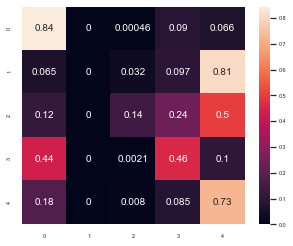

In [90]:
cm = confusion_matrix(y_test, eclf2_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(5,4))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

In [91]:
target_names = ['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
print(classification_report(y_test, eclf2_pred, target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.70      0.84      0.76      2159
           Died       0.00      0.00      0.00        31
     Euthanasia       0.70      0.14      0.23       322
Return_to_owner       0.50      0.46      0.48       950
       Transfer       0.76      0.73      0.74      1884

       accuracy                           0.69      5346
      macro avg       0.53      0.43      0.44      5346
   weighted avg       0.68      0.69      0.67      5346



c:\users\mftrivyza\documents\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### estimators= ('rf', clf), ('xgb', XGB_model), ('AdaBoostClassifier', bdt), voting='soft'

In [92]:
clf = RandomForestClassifier(n_estimators=115, min_samples_split=10,
                                                   min_samples_leaf=2, max_features='sqrt', max_depth=None,
                                                   bootstrap=True)

bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=500)


XGB_model = xgb.XGBClassifier(reg_alpha=1.77827941, n_jobs=-1, colsample_bytree=0.5722532094026564, 
                              objective='multi:softprob', n_estimators=115, max_depth=22, 
                              learning_rate=0.07578955028741008, subsample=0.848348985132586)


eclf3 = VotingClassifier(estimators=[('rf', clf), ('xgb', XGB_model), 
                                     ('AdaBoostClassifier', bdt)], voting='soft')
eclf3.fit(X_train,y_train)

eclf3_pred = eclf3.predict(X_test)
print("Voting Accuracy: {}%".format(eclf3.score(X_test, y_test)*100))

Voting Accuracy: 69.62214739992518%


#### estimators = ('xgb', XGB_model), ('AdaBoostClassifier', bdt), voting='soft'

In [93]:
eclf4 = VotingClassifier(estimators=[('xgb', XGB_model), 
                                     ('AdaBoostClassifier', bdt)], voting='soft')
eclf4.fit(X_train,y_train)

eclf4_pred = eclf4.predict(X_test)
print("Voting Accuracy: ", eclf4.score(X_test, y_test))

Voting Accuracy:  0.6930415263748597


#### Using Cross validation

In [94]:
print(np.mean(cross_val_score(eclf1, X_train, y_train, cv=5)))
print(np.mean(cross_val_score(eclf2, X_train, y_train, cv=5)))
print(np.mean(cross_val_score(eclf3, X_train, y_train, cv=5)))
print(np.mean(cross_val_score(eclf4, X_train, y_train, cv=5)))
print(np.mean(cross_val_score(XGB_model , X_train, y_train, cv=5)))

0.6845625206551107
0.6406020367388121
0.6898002739652324
0.6884905841128599
0.6917952412361641


### Train model with all training set and predict test set to submit on kaggle

In [95]:
X = f_train.values
y = labels.ravel()

In [96]:
X_train, y_train = X, y
X_test = f_test.values

print(X_test.shape)
print(X_train.shape)

(11456, 196)
(26729, 196)


In [97]:
model = xgb.XGBClassifier(reg_alpha=1.77827941, n_jobs=-1, colsample_bytree=0.5722532094026564, 
                          objective='multi:softprob', n_estimators=115, max_depth=22, 
                          learning_rate=0.07578955028741008, subsample=0.848348985132586, 
                          tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

In [98]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5722532094026564, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints=None,
              learning_rate=0.07578955028741008, max_delta_step=0, max_depth=22,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=115, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=1.77827941, reg_lambda=1,
              scale_pos_weight=None, subsample=0.848348985132586,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [99]:
proba = model.predict_proba(X_test)

In [100]:
proba.shape

(11456, 5)

In [101]:
submission = pd.DataFrame({'ID': animal_test_id.ravel(), 'Adoption': proba[:, 0], 'Died': proba[:, 1],
                           'Euthanasia': proba[:, 2], 'Return_to_owner': proba[:, 3],
                           'Transfer': proba[:, 4],})

In [102]:
submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.030897,0.002532,0.024582,0.076386,0.865603
1,2,0.829955,0.004971,0.009309,0.104492,0.051273
2,3,0.267433,0.005038,0.038771,0.354689,0.334069
3,4,0.302428,0.009295,0.016974,0.191582,0.479722
4,5,0.278978,0.002762,0.017809,0.647872,0.052578


In [103]:
submission.to_csv('data\our_submit.csv',index=False)

Multiclass loss = 0.72753 -> top 15% at kaggle